In [1]:
import fastai
from fastai.text.all import *
from pathlib import Path

In [2]:
path = untar_data(URLs.HUMAN_NUMBERS)

path.ls()

(#2) [Path('/home/.fastai/data/human_numbers/valid.txt'),Path('/home/.fastai/data/human_numbers/train.txt')]

In [3]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [4]:
len(lines)

9998

In [5]:
lines[0]

'one \n'

In [6]:
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [7]:
## tokenize
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [8]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [9]:
word2idx = {w:i for i,w in enumerate(vocab)}
word2idx

{'one': 0,
 '.': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'twenty': 20,
 'thirty': 21,
 'forty': 22,
 'fifty': 23,
 'sixty': 24,
 'seventy': 25,
 'eighty': 26,
 'ninety': 27,
 'hundred': 28,
 'thousand': 29}

In [10]:
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

In [11]:
L((tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [12]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3))

In [13]:
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [14]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs = 64, shuffle = False)

In [15]:
## Language model in pytorch

In [16]:
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        
    def forward(self, x):
        h = F.relu(self.h_h(self.i_h(x[:, 0])))
        h = h + self.i_h(x[:, 1])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:, 2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)

In [17]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func = F.cross_entropy, metrics = [accuracy])

In [18]:
%%time
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.063525,1.868073,0.460423,00:02
1,1.396311,1.741027,0.464464,00:02
2,1.395319,1.648368,0.477775,00:02
3,1.396222,1.619111,0.494176,00:02
4,1.369929,1.678609,0.426432,00:02


CPU times: user 49 s, sys: 1.19 s, total: 50.2 s
Wall time: 13.8 s


In [19]:
n, counts = 0, torch.zeros(len(vocab))
for x,y in dls.valid :
    #print (y.shape)
    n += y.shape[0]
    for i in range_of(vocab):
        counts[i] += (y == i).long().sum()

In [20]:
counts[0], len(counts), len(vocab)

(tensor(106.), 30, 30)

In [21]:
i

29

In [22]:
y

tensor([25,  9, 28,  9, 28,  1,  9,  2, 29, 26,  9, 28,  1,  9,  5, 29, 26,  9,
        28,  1,  9,  8, 29, 26,  9, 28,  9, 28,  1,  9,  2, 29, 27,  9, 28,  1,
         9,  5, 29, 27,  9, 28,  1,  9,  8, 29, 27])

In [23]:
y == i

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False])

In [24]:
(y == i).long()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [25]:
(y == i).long().sum()

tensor(6)

In [26]:
n

4207

In [27]:
idx = torch.argmax(counts) ; idx

tensor(29)

In [28]:
idx.item()

29

In [29]:
vocab[idx.item()]

'thousand'

In [30]:
counts[idx].item() / n

0.15165200855716662

In [31]:
## random accuracy = 15%
## our baseline model accuracy - 49%

In [32]:
## our first rnn model

In [33]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [34]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func = F.cross_entropy,
                metrics = [accuracy])

learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.793204,2.051027,0.438792,00:02
1,1.394189,1.808800,0.466366,00:02
2,1.427380,1.659169,0.489660,00:02
3,1.396514,1.707816,0.424531,00:02


In [35]:
## hidden state - the activations that are updated at each step of a rnn

In [36]:
## maintaning the state of an rnn

In [37]:
## to remove the gradient history in pytorch, we use the detach method

In [38]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, n_hidden)
        self.h = 0
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        
        return out
    
    def reset(self):
        self.h = 0

In [39]:
len(seqs)

21031

In [40]:
seqs[0]

(tensor([0, 1, 2]), 1)

In [41]:
bs

64

In [42]:
len(seqs) / bs

328.609375

In [43]:
len(seqs) // bs

328

In [44]:
m = len(seqs) // bs

In [45]:
m, bs, len(seqs)

(328, 64, 21031)

In [46]:
63*328

20664

In [47]:
def group_chunk(ds, bs):
    m = len(ds) // bs
    print (m)
    new_ds = L()
    for i in range(m):
        new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [48]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunk(seqs[:cut], bs),
                             group_chunk(seqs[cut:], bs),
                             bs = bs, drop_last = True, shuffle = False)

262
65


In [49]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func = F.cross_entropy,
                metrics = [accuracy], cbs = ModelResetter)

In [50]:
learn.to("cuda")

LMModel3(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=64, bias=True)
)

In [51]:
torch.cuda.empty_cache()

In [52]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.775140,1.866404,0.480529,00:03
1,1.264527,1.677850,0.481010,00:03
2,1.067035,1.552077,0.551442,00:03
3,0.997819,1.652430,0.547115,00:03
4,0.947706,1.675855,0.561298,00:03
5,0.900315,1.679035,0.583173,00:03
6,0.844704,1.688965,0.595433,00:03
7,0.812817,1.543354,0.612019,00:03
8,0.781453,1.579977,0.622596,00:03
9,0.759960,1.615724,0.626923,00:03


In [53]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1 : i + sl + 1]))
          for i in range(0, len(nums) - sl - 1, sl))
cut = int(len(seqs) * 0.8)

In [54]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [55]:
seqs[0]

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]),
 tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9]))

In [56]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim = 1)
    
    def reset(self): self.h = 0

In [57]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [58]:
x,y = dls.one_batch()

In [59]:
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64]))

In [60]:
y

tensor([ 1, 28,  3, 28,  7,  8,  1,  1, 27, 29,  0,  6,  0,  0,  9,  6, 28,  2,
         6, 28,  1, 28, 29, 13,  2,  1, 24,  5,  1,  1,  3, 25,  0,  4, 28,  4,
         5, 28,  4,  5, 29,  1, 28,  5, 21, 29,  1, 26,  6, 22,  3,  6, 27, 17,
         4, 28,  1,  1, 29,  9, 28, 29,  9,  7])

In [61]:
y.view(-1)

tensor([ 1, 28,  3, 28,  7,  8,  1,  1, 27, 29,  0,  6,  0,  0,  9,  6, 28,  2,
         6, 28,  1, 28, 29, 13,  2,  1, 24,  5,  1,  1,  3, 25,  0,  4, 28,  4,
         5, 28,  4,  5, 29,  1, 28,  5, 21, 29,  1, 26,  6, 22,  3,  6, 27, 17,
         4, 28,  1,  1, 29,  9, 28, 29,  9,  7])

In [62]:
x.view(-1)

tensor([ 0,  1,  2, 11,  1,  2, 25,  7,  1,  5,  1,  5, 28, 12,  1,  8, 28, 25,
        29, 22,  6, 28, 25,  8, 29,  2, 28, 13,  1,  0,  5, 28, 21,  1,  0, 29,
        24,  4,  1,  8, 28, 26,  1,  0, 29,  0, 28, 22,  2, 29,  2, 25,  9,  1,
         4, 28, 27,  2, 29,  6, 28, 21,  2,  2, 29,  8,  5,  1,  2, 29,  0, 28,
         1,  3, 29, 28, 22,  7, 29,  4, 28,  1,  3, 29, 28, 27,  7,  8, 28, 16,
        21,  3,  1,  1,  4, 29,  1,  4, 29, 28, 14,  1,  4, 29,  4, 22,  8,  1,
         6, 28, 24,  4, 29,  7, 27,  8,  1, 20,  5,  1,  3,  1,  5,  2, 28, 26,
         5, 29,  3,  1,  5, 29, 29,  6, 28,  9,  1,  5, 28, 24,  6, 29,  9, 28,
        21,  0,  1, 29,  2, 28,  1,  6, 29, 26,  0,  1, 29,  5, 28, 29,  7, 28,
         8, 28, 21,  6, 29,  9, 29, 27,  5,  2, 28, 15,  2,  1,  7,  4, 28, 22,
         7, 29,  5,  2,  1,  7,  7, 28, 27, 28, 18,  1])

In [63]:
bs = 64
dls = DataLoaders.from_dsets(group_chunk(seqs[:cut], bs),
                             group_chunk(seqs[cut:], bs),
                             bs = bs, shuffle = False,
                             drop_last = True)

49
12


In [64]:
x,y = dls.one_batch()

In [65]:
x.shape, y.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

In [66]:
x

tensor([[ 0,  1,  2,  ...,  1,  8,  1],
        [ 2, 28, 11,  ..., 28, 14,  1],
        [ 6,  1,  3,  ..., 28, 25,  9],
        ...,
        [ 7, 29,  6,  ...,  1,  7, 29],
        [28, 26,  0,  ...,  7, 28, 26],
        [ 7,  1,  7,  ..., 27,  9,  1]])

In [67]:
y[0]

tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])

In [68]:
x[0]

tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1])

In [69]:
y

tensor([[ 1,  2,  1,  ...,  8,  1,  9],
        [28, 11,  1,  ..., 14,  1,  2],
        [ 1,  3, 28,  ..., 25,  9,  1],
        ...,
        [29,  6, 28,  ...,  7, 29,  6],
        [26,  0,  1,  ..., 28, 26,  3],
        [ 1,  7, 29,  ...,  9,  1,  7]])

In [70]:
y.view(-1)

tensor([1, 2, 1,  ..., 9, 1, 7])

In [71]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func = loss_func,
                metrics = accuracy, cbs = ModelResetter)

In [72]:
learn.to("cuda")

LMModel4(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [73]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.176683,3.015017,0.346029,00:02
1,2.275389,1.944346,0.464193,00:02
2,1.719252,1.805481,0.465495,00:02
3,1.440933,1.988345,0.428385,00:02
4,1.268063,1.893156,0.538005,00:02
5,1.152140,1.793194,0.519450,00:02
6,1.048050,1.794085,0.560140,00:02
7,0.966877,1.831328,0.564779,00:02
8,0.899862,1.910296,0.575765,00:02
9,0.860902,1.793428,0.570638,00:02


In [74]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first = True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self):
        self.h.zero_()

In [75]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2),
                loss_func = CrossEntropyLossFlat(),
                metrics = accuracy,
                cbs = ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.028404,2.636201,0.338298,00:03
1,2.140126,1.819728,0.471110,00:02
2,1.697969,1.914252,0.329102,00:02
3,1.502005,1.828901,0.434082,00:02
4,1.340618,1.696417,0.481120,00:03
5,1.176616,1.665526,0.519694,00:02
6,0.996413,1.533898,0.515137,00:02
7,0.850094,1.571767,0.514486,00:03
8,0.742787,1.687974,0.514730,00:03
9,0.660529,1.745036,0.509033,00:02


In [76]:
## our single layer rnn worked better because multi layer rnn has a chance of vanishing or exploding gradients

In [77]:
## In RNN we had one hidden state, but in LSTM we have two hidden states, Hidden state help us in 
## 1. having the right information for the output layer to predict the correct next token.
## 2. retaining memory of everything that happened in the sentence 

In [78]:
## In LSTM we have cell state - which is responsible for keeping long short term memory, while hidden state is used to focus on the next token to predict

In [79]:
## building an LSTM

In [80]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate = nn.Linear(ni + nh, nh)
        self.cell_gate = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)
        
    def forward(self, input, state):
        h,c = state
        h = torch.stack([h, input], dim = 1)
        forget = torch.sigmoid(self.forget_gategate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = out * torch.tanh(c)
        return h, (h,c)

In [81]:
## refactored and optimised code

In [82]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni, 4*nh)
        self.hh = nn.Linear(nh, 4*nh)
        
    def forward(self, input, state):
        h,c = state
        # One big multiplication for all the states is better than 4 smaller ones
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate, forgetgate, outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()
        
        c = (forgetgate *c) + (ingate * cellgate)
        h = outgate * c.tanh()
        return h, (h, c)

In [86]:
torch.arange(11).chunk(4,)

(tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([ 9, 10]))

In [87]:
torch.arange(11).chunk(2, )

(tensor([0, 1, 2, 3, 4, 5]), tensor([ 6,  7,  8,  9, 10]))

In [88]:
## training a language model using LSTM

In [92]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first = True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self):
        for h in self.h : h.zero_()

In [93]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2),
                loss_func = CrossEntropyLossFlat(),
                metrics = accuracy,
                cbs = ModelResetter)

In [94]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.998760,2.702487,0.305990,00:03
1,2.200390,1.756889,0.460775,00:03
2,1.639697,1.699353,0.487793,00:03
3,1.364824,1.957832,0.476481,00:03
4,1.172055,2.067166,0.503255,00:03
5,0.983346,1.962176,0.557292,00:03
6,0.740874,1.860632,0.615234,00:03
7,0.492307,1.778017,0.681885,00:03
8,0.320050,1.721262,0.727458,00:03
9,0.214866,1.692271,0.748372,00:03


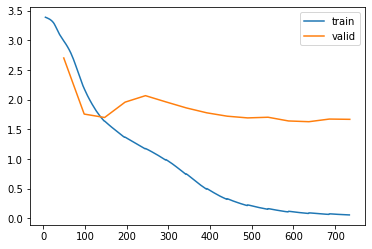

In [95]:
learn.recorder.plot_loss()

In [96]:
## Regularizing an LSTM

In [97]:
## dropout

In [98]:
## dropout helps the neurons to cooperate better together, then it makes the activations more noisy thus making
## the model more robust

In [99]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training : return x
        mask = x.new(*x.shape).bernoulli_(1 - p)
        return x * mask.div_(1-p)

In [100]:
x = torch.arange(10)
x

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [101]:
x.shape

torch.Size([10])

In [102]:
p = 0.2
m = x.new(*x.shape).bernoulli_(1-p)

In [103]:
m

tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [104]:
m/1-p

tensor([ 0.8000,  0.8000,  0.8000,  0.8000, -0.2000, -0.2000, -0.2000, -0.2000,
         0.8000,  0.8000])

In [106]:
## activation regularization and temporal activation regularization
## in weight decay we add a small penalty to reduce the weight to as small as possible. in lstm we try to make the final activations
## as small as possible instead of the weights.

In [107]:
## loss += alpha * activations.pow(2).mean().

## Temporal activation regularization is linked to the faxct we are predicting tokens in a setence. When we read them in order,
## TAR is there to encourage that output of LSTM should make sense when we read them in order.
## TAR is there to add a penalty to the loss and make the difference between 2 activations as small as possible.
## our activation tensor has shape - (bs * sl * n_hid) and we read consecutive activ on the sl axis
## loss += beta * (activations[:, 1:] -  activations[:, -1]).pow(2).mean()
## alpha and beta are 2 hyperparams to tune
## Activation regularization is often applied on the dropped out activations
## TAR is applied on the non dropped out acts

In [108]:
## training a weight tiedd regularized LSTM

In [109]:
## here we assign the same weight matrix to the embedding layer and the output layer because
## our embedding layer maps vocabulary to activations and 
## the output hidden layer maps activation to vocabulary
## intuitively these mappings could be the same so we assign the same weight matrix

In [110]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first = True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw, h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out), raw, out
    
    def reset(self):
        for h in self.h : h.zero_()

In [111]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func = CrossEntropyLossFlat(),
                metrics = accuracy,
                cbs = [ModelResetter, RNNRegularizer(alpha = 2, beta = 1)])

In [112]:
## Text learner automatically adds cbs for us
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func = CrossEntropyLossFlat(), metrics = accuracy)

In [113]:
learn.fit_one_cycle(15, 1e-2, wd = 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.512929,2.016880,0.506836,00:03
1,1.564199,1.379075,0.599935,00:03
2,0.840838,0.853399,0.773682,00:03
3,0.416019,0.959748,0.808024,00:03
4,0.208302,0.911576,0.816895,00:03
5,0.113943,0.841154,0.822184,00:03
6,0.069178,0.892808,0.838053,00:03
7,0.044836,0.890409,0.842285,00:03
8,0.032113,0.829500,0.836914,00:03
9,0.025212,0.775771,0.852865,00:03
